---
layout: AIX-Intro-B3.ipynb
title: A Gentle Introduction to AI Explainability - part 3: LIME Example
description: LIME Example.
tags:
  - AI Explainability
  - AI Fairness
  - Machine Learning
  - Artificial Intelligence
  - LIME
authorGithubAlias: cyrusmv
authorName: Cyrus Vahid
date: 2022-07-08

---


# A Gentle Introduction to AI Explainability - part 3: LIME Example

## Context
In [part 2](./AIX_Intro-B2.ipynb) we went through the theoretical explanation of the LIME paper. In this part we implement an object detection example.
You can find the full code [here](AIX/LimeExample.ipynb).

 Example: Object detection explanation
In this example we try using LIME's image explainer on 3 pictures, one of lions and two of cheetahs using two different deep learning models, inceptionV3 and resnet152. We then look at the regions that are picked for detecting the what animal appears in the picture and see if the explanation makes sense to humans. We start with the following high resolution images. We then transforms the images and run them through our models to attain a probabilistic prediction.

## Original Images
<figure>
    <img src="data/originals.jpg" alt='Original Images'  style="float:left"/>
    <figcaption>Figure 1: Original images. Next we 1) transform the images, 2) make predictions using two different algorithms, 3) produce explanations, and 4) analyze the explanations.</figcaption>
</figure>

## Images after transformation

```python
# We center crop the image with a large enough space for the main subject to be included in the picture.
# I tried 1500 pixels and it worked for all three pictures. Then using transform, we resuze the picture to 
# the size that is compatible with ImageNet based algorithms. 
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.CenterCrop(1500),
        transforms.Resize((256, 256)),        
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)
```

## Applying the transformation
```python
transformed_images = []
nimgT = transforms.ToPILImage()
for image in img:
    get_input_tensors(image)[1:].shape
    transformed_images.append(nimgT(get_input_tensors(image).squeeze()))
```
## transformed images 
<figure>
    <img src="data/processed.png" alt='transformed images'  style="float:left"/>
    <figcaption>Figure 2: As it can be observed, the processed images are already not useful to the humans. Next we 1) make predictions using two different algorithms, 2) produce explanations, and 3) analyze the explanations.</figcaption>
</figure>



## Choosing models we want to explain
```python
model1 = models.inception_v3(pretrained=True)
model2 = models.resnet152(pretrained=True)
```

## Model Predictions
After loading the models we run a prediction on both models. The results are summarized in table 1:

<figure>
    <img src="data/inception.png" alt='predictions: inception v3'  style="float:left"/>
    <figcaption></figcaption>
</figure>
<figure>
    <img src="data/resnet152.png" alt='predictions: resnet152'  style="float:left"/>
    <figcaption>Table1:predictions. The table on the top includes the top5 predictions from inception v3. The other table includes the results from resnet-152. We can see that inception is quite certain about its top choice. Still we do not know why and how the model has made such decision or how did animals like gazelle made it to the top5, however low the priority maybe. the same story applies to resnet, except that for the first image the prediction gives a 70% probability for cheetah.</figcaption>
</figure>

## Preparing explanations
We now Prepare to create an explainer. Let us remember what the process for creating location Lime a perturbation algorithm on the original images. It then uses the perturbed data to train an explainer model. This means we need to provide the original image and the original classification function to `LimeImageExplainer` so that LIME can produce probabilities for the perturbed dataset. 
In the next step we prepare or provide the following to LIME to train a generic explainer using: `lime.lime_image.LimeImageExplainer()`.

1. Classifier $f$ that we aim to explained. In our case inception-v3 and resnet-152.
2. pre-processed original images $x$.

### Data Transformers
```python 
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
```

`pill_transf` is a transformer based on `get_pil_transform` that takes an image and performs standard resizing and center cropping for imagenet-based models. Obviously you can change the transformer based on whatever model use are using as high-resolution models have gained popularity in recent years.

*`pill_transf` is used by the original model $f$ to make predictions on the original image.*

`preprocess_transform` is another transformer that basically normalizes the image based on a pre-defined mean and variance per dimension. 

*`preprocess_transform` is used to generate an instance explainer where the perturbation process is applied and the explainer model is trained.*

Given an image `pill_transf` returns tensors of the shape (3, 224, 224), which is in channel first layout or BCHW (Batch, Channel, Height, Width and as we are processing only a single image $x$, B=0 and is omitted). If you are using frameworks that require channel last or BHWC, then you need to transpose the tensor.

### Predictor
As we have seen we are using inception-v3 and resnet-152, respectively denoted by model1 and model2 in this example.

The following function `batch_predictor`, simply uses the model to make a prediction. The predictor function is later passed to `lime.lime_image.LimeImageExplainer()` in order to make predictions on the perturbed data.

```python
def batch_predict1(images):
    model1.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model1.to(device)
    batch = batch.to(device)
    
    logits = model1(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()
```
This function simply take a list of images and perform prediction using the original model. This specific function uses our `model`, which we defined earlier as `model1 = models.inception_v3(pretrained=True)`
. 

### Generating the local explainer
`explainer` is defined as a `LimeImageExplainer`. As seen in the LIME paper, for categorical features, `LimeImageExplainer` perturbs the data by sampling according to the training distribution, and making a binary
feature that is 1 when the value is the same as the instance being explained. Kernel width can be passed to this function as a parameter.  

As we are performing a local explanation, we call `explain_instance` method of our `explainer` and pass the original image `pill_transf` version of the original image along with other parameters, amongst them most notably is `num_samples`, which as the name indicates, defines how many times the model would be run and how many perturbations there are. 

`explain_instance` returns a `lime.lime_image.ImageExplanation` object that contains data about explanations. Most notably it includes segmentation information `ImageExplanation.segment` and make information `ImageExplanation.get_image_and_mask()`

```python
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanations1 = []
explanations2 = []
for image in img:
    explanations1.append(explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict1, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) )
    explanations2.append(explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict2, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) )
    
    
```

At the next step we use `ImageExplanation.segment` to visualize segmentation information as a way of explaining which regions of image were used by the predictor model to determine the classification probabilities.

### Visualization
Finally we use skimage to visualize the segmentation we have acquired through `ImageExplanation.get_image_and_mask().`

```python
from skimage.segmentation import mark_boundaries
ib = []
for explanation in explanations1:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    ib.append(mark_boundaries(temp/255.0, mask))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ib):
    ax.imshow(im)
```

This is only the code sample for model1-e.g. inception-v3. You will find in the accompanying code notebook that we have performed the computation for both models. Next we can see the result of visualization for all three images and both models. It is notable that the segmentation includes the environment and not just the object itself. This can explain why completely different looking savanna animals were included in the top5 selection. This, however is a hypothesis as trying the model with other animals such as gazelle could clarify the role of background, environment, and climate.

<figure>
    <img src="data/inceptionexplain.png" alt='predictions: inception v3'  style="float:left"/>
    <figcaption>Figure 3: Segmentation generated by LIME. The regions in this segmentation are used to determine the classification of the object in the image. The underlying model in this case is inceptino-v3 and LIME has performed as a model agnostic post-hoc local explainer. </figcaption>
</figure>

<figure>
    <img src="data/resnetexplain.png" alt='predictions: resnet-512'  style="float:left"/>
    <figcaption>Figure 4: Segmentation generated by LIME. The regions in this segmentation are used to determine the classification of the object in the image. The underlying model in this case is resnet-512 and LIME has performed as a model agnostic post-hoc local explainer. </figcaption>
</figure>

# What is next?
in [part 4](./AIX_Intro-B4.ipynb) we introduce Shapley value and collaborative games, which is the foundation for SHAP method.

# Additive feature attribution methods
Additive feature attribution methods have a an explanation model that is a linear function of binary variables.
$$
\large{
g(z^{\prime}) = \phi_0 + \sum_{i=1}^M\phi_iz^\prime_i
}
$$
where $z^\prime \in \{0,1\}^M$, and $M$ is the number of simplified input features, and $\phi_i \in \mathbb{R}$.

Family of explanation models that matching definition of additive feature attribution models assign an attribution $\phi_i$ to each feature and then sum up the effects of all features to approximate the original model $f$ over a specific input. 
In the following sections we explain such three of such models as well as their practical application. Each model is accompanied by relevant code notebook running through an example.

Additive feature attribution methods have *desirable* properties that uniquely determine additive feature attribution.

### Local accuracy
Local accuracy requires the explanation model $g$ to at least match the output of original model $f$ for the simplified input $x^\prime$.

### Missingness
features that are missing from the simplified input, which describe in binary terms where or or not a feature is present, must have no impact, or $x_i^\prime = 0 \Rightarrow \phi_i=0$.

### Consistency
If a model changes in a way that impact of a feature increases, the attribution should never decrease.

# SHAP and Explainability
Feature attribution is one of the main areas of focus in explainability research and implementation. Feature attribution is essence calculates how much each input feature contributes to a decision made by the model. Self evidently, feature attribution models can be applied post-hoc and as a black-box explainer. Prominent amongst feature attribution methods are those based on Shapley values, proposed in 1952 by Nobel Prize laureate (2012) Lloyd Shapley in game theory in the context of cooperative n-person games. To understand application of Shapley values in model explanation, let us first take a brief look at n-person cooperative games and Shapley method.

## Cooperative n-person games
Fundamentally,  How The problem is to measure what contribution each player makes. Let's think in terms of a football (soccer) team. The aim of the game is to score, perhaps as many as you can if you are a proper team. Imagine a team would like to reward the whole team a certain reward based on the position in the league after the end of a season. team as well as club employees such as kit man, coaching, and medical staff based on their contribution. Obviously no one thinks that only goal scorers should be rewarded. The problem is to computer what impact each player has had in success of the team.
Another example is a sales organization within a IT vendor company. There are account managers, solutions architects, inside sales, technical account managers, and many other in the account team as well as specialist support teams that contribute to a sale. How should the commission be distributed? What is the exact contribution of a solution architect to the success of a transaction? They story goes. What is the direct contribution of marketing to the total revenue? 
These are all n-player games in competitive situations. There is a total amount of available commission to be distributed amongst the account team and the team members, although in a tight alliance, compete over having a bigger chunk of the available rewards. Marketing, PR, and other support teams compete over the amount of available budget based on their contribution, even though in the grand scheme of things are tightly allied for the benefit of the company. 
Lloyd shapley proposed a solution to this problem. In the next section, I will introduce Shapley values. They are relevant to model explanation as we can use Shapley values to measure how much each feature contributes to the final decision of a model.

### Definitions
#### Coalition Function
Imagine a sales team. if the team has $N$ members and their coalition has a payout. Now if we create permutations of team members by changing the order or removing one or more members from the team, we still would have a payout that is either the same or lower, or perhaps, unlikely as it might be,higher. 
Let's imaging we have three players $A, B,$ and $C$. The coalition set in this case is $\{\{\} = \phi, \{A\}, \{B\}, \{C\}, \{A,B\}, \{A,C\}, \{B,C\}, \{A,B,C\}=\Omega \}$. We can see that for a coalition of $3$ we have $2^3$ permutations with each permutation resulting in some payout. For N players, there will be 
The total number of coalitions for $N$ players we have $2^N$ coalitions and each coalition has a payout. A grand coalition is a coalition that includes all the player. In this example $\{A,B,C\}$ is the grand coalition. We define characteristic or coalition function as a function that projects each of the coalitions to a payout. More formally:

Let $N=\{p_1, p_2, \dots, p_n\}$ be all the players in a game $G$ with $|N|=[N]$. Each non empty $S \subseteq N$ is called a coalition. A grand coalition is a coalition of all players in the game and is denoted by $\Omega$.

***Definition:*** *A characteristic function game $G$* is given by $(N,v)$ where $v:2^{[N]} \rightarrow \mathbb{R}$ is a coalition function that maps every $S_i \in S$ (all coalitions + empty subset to a payout. 

Let us consider the sales example where A is the account manager, B the solutions architect, and C the technical account manager. The below table is the coalition function with the hypothetical payout values:

| Coalition | Payout |
|-----------|--------|
| $\phi$    | 0      |
| A         | 100K   |
| B         | 80K    |
| C         | 65K    |
| A,B       | 160K   |
| A,C       | 140K   |
| B,C       | 100K   |
| A,B,C     | 250K   |

Let us contemplate as what the payout function is telling us. 
<figure>
    <img img align="right" width="200" height="200" src='data/venngame.png'>
    <figcaption>
    </figcaption>
</figure>
- A has the highest impact on this specific sale, followed by B, and then C. 
- A and B together can make a sale with a total value of 180. C adds 70 to the total. 
- B individually makes a total revenue of 80 and C adds only a contribution of 20, a far cry form individual contribution of 65. This does not seem to be a good coalition. It even makes causal sense as the two technical resources have many areas of overlap in terms of skillset.
- C makes a total contribution of 40 when paired with A. It is a much better contribution, but the maximum effectiveness comes where all members of the coalition are working together.

We can conclude C is most successful when A is in the coalition.

#### Superadditive
We all have heard of teams whose total is more that total sum of its members. This is basically intuition for the superadditive characteristic function game. More accurately we have for each combination of distinct coalitions, if the total payout of the combined coalition is more than or equal the total sum of its coalition members. The distinctness does make sense. Let us consider the case of $\{C_A=\{A\}, C_{AB=}\{A,B\}\}$. There is a hidden double counting of contribution of $A$ so we should account for it. In the case of our example $v(C_A)=100,v(C_B)=80,\ v(C_{AB})=160;\ 160=v(C_{A,B}) < v(C_A) + v(C_B) = 180$ does not contradict super additiveness. How about $v(C_{AB})$ and $v(C_C)$ where the two coalitions are distinct? $v(C_{AB}) = 160,\ v(C_C) = 65, and  v_{ABC}=250;\ 225 = v(C_{AB}) + v(C_B) \leq v(C_{ABC}) = 250$ does not contradict superadditiveness.

***Definition*** A characteristic function game $G=(N,v)$ is called *super additive* when:
$$
\large{\forall\ C_i\subseteq S,\ where\ \cap_{i=1}^{[N]}C_i =\phi :\   v(\cup_{i=1}^{[N]}C_i) \geq \sum_{i=1}^{[N]}v(c_i)}
$$
 
***Question:*** *Is the sale example a super additive characteristic game function?*

***Answer:*** We need to try an example that breaks superadditiveness. The case of $\{A, C\}$ results in $165 = v(C_A) + v(C_C) > v(C_{AC}) = 140$, therefore the sales example is not a superadditive game. Altering payouts to $v(C_{AC} \geq 165$ will make the game to be an example of a superadditive game. 

A solution to a coalition function game is a payoff vector that divides payouts amongst players in the grand coalition. More formally Shapley value is the vector $\lambda \in \mathbb{R}_{\geq 0}^{[N]}$ that satisfies:
$$
\large{ \sum_{i=1}^{[N]} \lambda_i = v(\Omega) }
$$

One obvious solution to the problem is of course equal payout, but this is unfair to the high performing players. A possible solution to our example is to choose $\lambda = [\frac{100}{250}, \frac{80}{250}, \frac{65}{250}]$. This means we consider impact only on the basis of individual performance. This is perhaps unfair to $C$ as he seems to excel in team settings where $A$ is present.

The goal of Shapley values is to find the fair distribution in relation to impact. This requires us to define Shapley axioms, which define a system in which Shapley values can be defined.

### Symmetry
Symmetry axiom represents interchangeability of two members, meaning that either of the members would always have the same marginal contribution no matter what coalition they are added to. Coalitions $C_i$ and $C_j$ with respect to coalition function $v \in G$ if adding it to a coalition that does not already include them results in the same payout. For instance if we have two additional players in the sale example,--e.g. inside sales and marketing-- with individual contribution of $v(C_D)=15$ and $v(C_E)=20$. $C_D$ and $C_E$ are symmetrical in respect the payout function if $v(C_{ABD}) = v(C_{ABE}) = 150$.
More formally:

$$
\forall K \subset S;\ where\ C_i \notin K\ and\ C_j \notin K\ and\ \forall v \in G:\\
\large{
v(K \cup C_i) = v(K \cup C_j)
}
$$

***Symmetry Axiom:*** Interchangeable members should receive the same share or:. $\large{\lambda_{C_i}(N,v) = \lambda_{C_j}(N,v)}$ for interchangeable players $C_i$ and  $C_j$.

### Null player
We all have had coworkers where we though what would happen if one day they did not show up. Would it affect anything? If the data supports your suspicion, then we have a null player. Basically a null player is a player that if added to a coalition, the payout value does not change. More formally:
A player $C_k$ is a null player in if:
$$
\forall v\in G\ and\ \forall K \subset S:\\
\large{
v(K) = v(K \cup C_k)
}
$$

***Null player axiom:*** Null(dummy) players should receive nothing or:. $\large {\lambda_{C_k}(N,v) = 0}$ for null player $C_k$.

### Additivity
Consider two independent games $G_!$ and $G_2$. For instance the same sales team from the previous example would be working on more than one sales initiative or sometimes more than one customer account at a given time. Let's say in January they maker a sales of a total value of 250K as given in the example and in the month of February, they close another sale at the different customer for 300K. These two games are independent of one another. There are two ways of looking at this. Either we are looking at a single game of total sales in a quarter, or we can break that game to individual games based on each sales. The quarterly games of selling services for this sales team can be split into independent games. It is often done very regularly by splitting annual sales to quarterly sales and rewarding sales them on the basis of their quarterly performance. Games that can be split into independent parts are additive. More precisely, *if a game can be separated into parts, we should be able to decompose the payments.*
***Additivity axiom:*** let $v_i$ and $v_j$ be two arbitrary payout functions and $C \subseteq S $ be an arbitrary non-empty coalition. The solution function $\lambda$ follows the additivity axiom if: 
$$\large{\lambda_C (v_i + v_j) = \lambda_C(v_i) = \lambda_C(v_j)}$$.

### Shapely theorm
Given a coalitional game $(N,v)$, there is a unique payoff division $x(v) = \lambda(N, v)$ that divides the full payoff of of the grand coalition and satisfies Symmetry, Null player, and additivity axiom. 

### Shapely Value
the Shapley value is calculation of the unique payoff division based on removing members and measuring what difference removal of a member has made. Then doing it for all members and in all possible ways and averaging over the possible ways we can constructed the society.

More formally:
$$
\large{
\lambda_i(N,v) = \frac{1}{N!}\sum_{S\subseteq N \setminus \{i\}}|S!|(|N|-|S|-1)! \left[ v(S \cup \{i\})-v(S)    \right]
}
$$
Let us dissect this a little bit: $\left[ v(S \cup \{i\})-v(S) \right ]$ is play $i$'s marginal contribution that is acquired through removing the player and looking at the total payout. We then weight the marginal contribution by $|S!|$, the number of ways set $S$ could be created before adding player $i$ and (|N|-|S|-1)!, the number of ways the rest of the players could have been added. Then all these possible ways of contributions by members is added up using $\sum_{S\subseteq N \setminus \{i\}}|S!|(|N|-|S|-1)! \left[ v(S \cup \{i\})-v(S)    \right]$. As we have summed up all the possible contributions, we average the total over the total of orderings we could have had by dividing the sum by $|N!|$.  

#### Example 
Let us restrict our example only to an account manager and a solutions architect. We know that we have a following payout table (I have changed $v(B)$ to 40 to have a superadditive game:

| Coalition | Payout |
|-----------|--------|
| A         | 100K   |
| B         | 40K    |
| A,B       | 160K   |

Let us calculate Shapley Value.
Let us focus on player $A$. We can add $A$ first. in this case $\lambda_A = v(C_A) = 100$. A could be added second in a sequence of B first and A second, thus resulting in the $B \rightarrow A$ sequence. Marginal contribution is now calculated as $v(C_{AB}) - v({C_B}) = 120$. The total sums up to 220 and as we are averaging over two possibilities $|N|! = 2$, so each variation is divided by 2 and payout for A comes to: $50+60 = 110$. We can then repeat the process focusing on B. $v(C_B) = 40$ and $v(C_{AB}) - v(C_A)=60$. By the same token, both values are divided by 2 and thus contribution of $B=20+30=50$. We can see that the total for the grand coalition is 110+50 = 160, which is equal to $v(C_{AB})$. 

$$\large{ \lambda (N=\{A,B\}, v) = \{110, 50}\}$$  

## SHAP for Explainability
So far we have seen that Shapley values provide a ***unique*** and ***fair*** way to distribute the payout amongst the players in a collaborative and competitive game. We have also seen references to feature attribution methods. Additionally we know from the context that SHAP is an additive feature attribution methods and thus has a linear local explanation based on simplified input.    

The authors of the SHAP paper[10] have provided an equation that is akin to Shapley values equation and prove that there is unique solution to that equation, which is composed of a conditional expectation function of the original model that is being explained. In this case the explanation model should satisfy the three properties of the additive feature attribution, which again are akin to three axioms of for Shapley theorm. The equation that needs to be answered is defined as:
$$
\large{
\phi_i(f,x) = \sum_{z^\prime \subseteq x^\prime} \frac{|z^\prime|!(M-|z^\prime|-1)!}{M!} \left[ f_x(z^\prime)-f_x(z^\prime \setminus i) \right]
}
$$
where $|z|$ is the number of non-zero entries in z, and $z \subseteq x$ represents all $z$ vectors where the non-zero entries are a subset of the non-zero entries in $x$. $f_x(z\prime) = E \left[ f(z) | z_S\right]$ where $S$ is a set of non-zero indexes in $z^\prime$

Comparing this equation to shapley values, we observe that $\phi = \{\phi_i:\ 0\ \leq i\ \leq M\}$. $f$, the original model is the payout function and $x$ denotes the grand coalition. finally $z$ is permutations of possible coalitions, which we saw in the simple example s we created those permutations. 

<figure>
    <img img align="center"  src='data/SHAP.png'>
    <figcaption>
        Figure 13: $[E(f(z)]$, corresponding to $\phi_0$ is the expectation of the model over input features. Then as we build all the possible alliances $x_1 = \rightarrow x_{1,2} \rightarrow x_{1,2,3}$ we get the conditional expectation  of $f(x)$ for the newly added feature. We should keep in mind that the solution is dependent on the order the population is generated in the cases where the features are dependent on one another or the model $f$ is non-linear.
    </figcaption>
</figure>

## Approximating SHAP values
Instead of heavy and complicated computation of SHAP values, we can approximate them with some accuracy. Authors of [10] has proposed two model agnostic methods of which we only focus on Kernel SHAP, which is a combination of LIME and Shapley values. Later in this document, we describe DeepLift and DeepSHAP, which combined DeepLift an Shapley values and is model specific.

### Kernel SHAP
We remember creating a LIME explanator resulted in solving the optimization 

$$
\large{\xi(x) = \text{arg} \min\limits_{g \in G} \mathcal{L}(f,g,\Pi_x) + \Omega(g)}
$$.

We should also note that choosing loss function and $\Omega$, and weighting kernel, $\Pi$ to solve the LIME optimization equation are empirical and based on heuristic methods, thus the explanations can vary depending on how we choose those hyperparameters. The question is whether we could do better and have a consistent and locally accurate solution. The answer is yes. Since LIME is a Additive feature attribution method, Shapley values are the unique solution to the problem of finding an explanator where the desired properties, local accuracy, missingness, and consistency are satisfied; therefore the question of consistency and local accuracy for LIME comes down to find the Shapley values to to find the hyperparameters $\Omega$, $\mathcal{L}$, and $\Pi$ and avoid heuristic methods.
The authors propose and prove the following values for the huperparameters to be the unique solution that satisfies the desired properties:
$$
\large{
\Omega(g)=0
}
$$
As seen earlier $\Omega$ represented complexity such as depth of a tree or the number of non-zero weights. This is heuristic and arbitrary. By setting it to $0$, we become independent of such arbitrary choice of complexity.

$$
\large{
\Pi_{x^\prime}(z^\prime)=\frac{M-1}{\left(M choose |z^\prime| \right )|z^\prime|\left( |M|-|z^\prime|\right )}
}
$$
The apparent similarity to weighting of Shapley values is obvious.

$$
\large{
\mathcal{L}(f,g,\Pi_{x^\prime}) = \sum_{z^\prime \in z} \left[ f(h_x^{-1}(z^\prime))-g(z^\prime)\right ]^2\Pi_{x^\prime(z^\prime)}
}
$$
$\mathcal{L}$ corresponds to the weighted average of the conditional expectations in the SHAP method.


## SHAP Example
I think the reader agrees with me that we need to stop with the theory and get into some coding examples.


# References
1. https://arxiv.org/pdf/1602.04938v1.pdf
2. https://arxiv.org/pdf/2011.07876.pdf
3. https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/
4. https://github.com/marcotcr/lime/tree/master/doc/notebooks
5. https://arxiv.org/pdf/1705.07874.pdf
6. https://vknight.org/Year_3_game_theory_course/Content/Chapter_16_Cooperative_games/
7. https://www.rand.org/content/dam/rand/pubs/papers/2021/P295.pdf
8. https://www.wifa.uni-leipzig.de/fileadmin/Fakultät_Wifa/Institut_für_Theoretische_Volkswirtschaftslehre/Professur_Mikroökonomik/Cooperative_game_theory/B1_gl.pdf
9. https://www.youtube.com/watch?v=9OFMRiAVH-w
10 https://arxiv.org/pdf/1705.07874.pdf


In [5]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

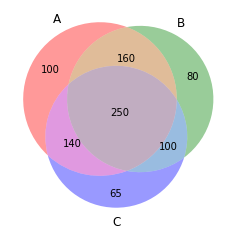

In [10]:

venn3(subsets = (100, 80, 160, 65, 140, 100, 250), set_labels = ('A', 'B', 'C'))

In [12]:
100/250, 80/250, 56/250


(0.4, 0.32, 0.224)